<a href="https://colab.research.google.com/github/skabra5/Sentiment-Analysis-using-Bag-of-Words-TFIDF-Features-and-Recurrent-Neural-Net/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Updating the file location
import os
path = '/content/drive/My Drive/Colab Notebooks/Sentiment Analysis Project'
os.chdir(path)


# Importing packages

In [0]:
!pip install TextBlob
!pip install unidecode

     |████████████████████████████████| 245kB 8.7MB/s 


In [0]:
# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from timeit import timeit
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
from textblob import TextBlob
from unidecode import unidecode

# Importing Training and Test Dataset into Pandas dataframe

Reading training data

In [0]:
traintxt=open('train_90.txt',"r")
trainlines= traintxt.readlines()
train_data = []
for x in trainlines:
    train_data.append(x.split(',',3))
traintxt.close()

In [0]:
# Data manipulation
train_df = pd.DataFrame(train_data)
train_df.columns = train_df.iloc[0]
train_df = train_df.rename({"SentimentText\n": "SentimentText"}, axis=1, inplace=False)
train_df= train_df.iloc[1:]
train_df=train_df[['ItemID', 'Sentiment', 'SentimentText']]
train_df['Sentiment']=train_df['Sentiment'].astype('str')
train_df['Sentiment']=train_df['Sentiment'].str.replace('1','Positive')
train_df['Sentiment']=train_df['Sentiment'].str.replace('0','Negative')
train_df['Sentiment']=train_df['Sentiment'].astype('category')
#train_df['Sentiment']=train_df['Sentiment'].astype('int')



In [0]:
train_df.info()

In [0]:
train_df.head(10)

Reading Test data 

In [0]:
testtxt=open('test_10.txt',"r")
testlines=testtxt.readlines()
test_data = []
for x in testlines:
    test_data.append(x.split(',',3))
testtxt.close()

In [0]:
# Data Manipulation
test_df = pd.DataFrame(test_data)
test_df.columns = test_df.iloc[0]
test_df = test_df.rename({"SentimentText\n": "SentimentText"}, axis=1, inplace=False)
test_df= test_df.iloc[1:]
test_df=test_df[['ItemID', 'Sentiment', 'SentimentText']]
test_df['Sentiment']=test_df['Sentiment'].astype('str')
test_df['Sentiment']=test_df['Sentiment'].str.replace('1','Positive')
test_df['Sentiment']=test_df['Sentiment'].str.replace('0','Negative')
test_df['Sentiment']=test_df['Sentiment'].astype('category')

In [0]:
test_df.head(10)

# Text Preprocessing of the tweets

In [0]:
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
        

def preprocess(text):
  text = text.lower()
  #text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text) # remove URLs
  text = re.sub('<.*?>', '', text)   # remove HTML tags
  text = re.sub(r'[^\w\s]', '', text) # remove punc
  text = re.sub(r'\d+','',text)# remove numbers
  #text = re.sub(r"[.?!]", '', text) 
  #text = re.sub('[0-9]+', '', text)
  text = re.sub('@(\w+)',"", text ) # remove usernames
  text = re.sub(r"[#|_]", '', text) # remove the # in #hashtag
  text = word_tokenize(text) # remove repeated characters (helloooooooo into hello)
  
  #removing stopwords and puncuations
  mystopword = set(nltk.corpus.stopwords.words('english') + ['URL'])
  text = [word for word in text if word not in mystopword]
  text = [word for word in text if word not in punctuation]

  # mystopwords = set(stopwords.words('english') + list(punctuation) + ['URL'])
    
  #apply lemmatizing
  wn = nltk.WordNetLemmatizer()
  text = [wn.lemmatize(word) for word in text]


  #apply stemming
  ps = nltk.PorterStemmer()
  text = [ps.stem(word) for word in text]
  
  return text
  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
%time train_df['Tweet'] = train_df['SentimentText'].apply(lambda x: preprocess(x))
%time test_df['Tweet'] = test_df['SentimentText'].apply(lambda x: preprocess(x))
# # train_df.head(10)

CPU times: user 39.1 s, sys: 1.28 s, total: 40.3 s
Wall time: 40.4 s
CPU times: user 4.25 s, sys: 151 ms, total: 4.4 s
Wall time: 4.4 s


In [0]:
%time train_df['Tweet'] = train_df.Tweet.apply(lambda x: ' '.join([str(i) for i in x]))
%time test_df['Tweet'] = test_df.Tweet.apply(lambda x: ' '.join([str(i) for i in x]))

CPU times: user 135 ms, sys: 11 ms, total: 146 ms
Wall time: 146 ms
CPU times: user 16.2 ms, sys: 6 µs, total: 16.2 ms
Wall time: 16.1 ms


In [0]:
train_df.head(10)

In [0]:
train_df.shape

(89974, 5)

In [0]:
# Removing rows with tweets length = 0
train_df = train_df[train_df.iloc[:,3].astype(str).str.len()!=0]
test_df = test_df[test_df.iloc[:,3].astype(str).str.len()!=0]
 

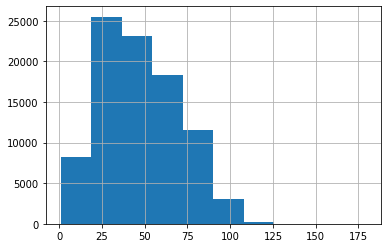

count    89974.000000
mean        47.389401
std         22.776592
min          1.000000
25%         29.000000
50%         45.000000
75%         65.000000
max        179.000000
dtype: float64

In [0]:
# Analyzing Train Tweet Length
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
tweets_len = [len(x) for x in train_df['Tweet']]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

# Exploratory Data Analysis

## Word Cloud for All tweets, positive sentiment tweets and negative sentiment tweets

CPU times: user 9.14 s, sys: 175 ms, total: 9.31 s
Wall time: 9.32 s


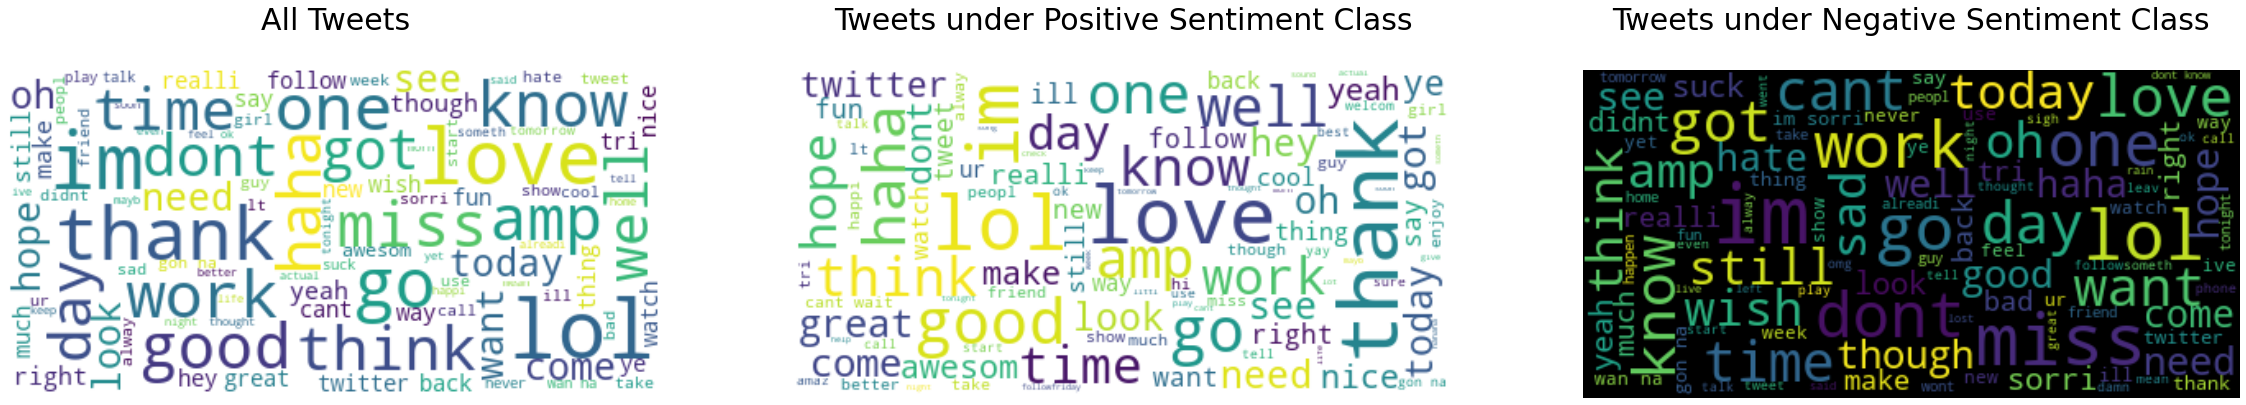

In [0]:
%%time 

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
# Start with one review:
df_pos = train_df[train_df['Sentiment']=="Positive"]
df_neg = train_df[train_df['Sentiment']=="Negative"]
tweet_All = " ".join(review for review in train_df.Tweet)
tweet_pos = " ".join(review for review in df_pos.Tweet)
tweet_neg = " ".join(review for review in df_neg.Tweet)

fig, ax = plt.subplots(1, 3, figsize  = (40,40))

# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_pos)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_neg)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets\n', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_pos, interpolation='bilinear')
ax[1].set_title('Tweets under Positive Sentiment Class\n',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_neg, interpolation='bilinear')
ax[2].set_title('Tweets under Negative Sentiment Class\n',fontsize=30)
ax[2].axis('off')


## Extracting most frequent unigrams and bigrams from positive and negative tweets

In [0]:
#TfidfVectorizer for text classification

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(train_df["Tweet"])

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(test_df["Tweet"])

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
#print(tfidf_train.A[:10])


['aa', 'aaa', 'aaaamerah', 'aaaand', 'aaah', 'aaahh', 'aafreen', 'aah', 'aahh', 'aahhh']


In [0]:
getFeatures_df = train_df
getFeatures_df['Sentiment_id'] = getFeatures_df['Sentiment'].factorize()[0]
sentiment_id_df = getFeatures_df[['Sentiment', 'Sentiment_id']].drop_duplicates().sort_values('Sentiment_id')
sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[['Sentiment_id', 'Sentiment']].values)
labels = getFeatures_df.Sentiment_id
getFeatures_df.head()

,ItemID,Sentiment,SentimentText,Tweet,Sentiment_id
1,1,Negative,is so sad for my APL friend.............\n,sad apl friend,0
2,2,Negative,I missed the New Moon trailer...\n,miss new moon trailer,0
3,3,Positive,omg its already 7:30 :O\n,omg alreadi,1
4,4,Negative,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2...,omgaga im sooo im gunna cri ive dentist sinc supos get crown put min,0
5,5,Negative,i think mi bf is cheating on me!!! T_T\n,think mi bf cheat tt,0


In [0]:
from sklearn.feature_selection import chi2
import numpy as np
N = 3
for Sentiment, Sentiment_id in sorted(sentiment_to_id.items()):
  features_chi2 = chi2(tfidf_train, labels)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Sentiment))
  print("Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Negative':
Most correlated unigrams:
. miss
. sad
. thank
Most correlated bigrams:
. thank follow
. sorri hear
. im sorri
# 'Positive':
Most correlated unigrams:
. miss
. sad
. thank
Most correlated bigrams:
. thank follow
. sorri hear
. im sorri


# Baseline Sentiment Classification Model using TextBlob

In [0]:
def analyze_sentiment(tweet):
  analysis = TextBlob(tweet)
  polarity = analysis.polarity
  subjectivity = analysis.subjectivity
  
  if analysis.sentiment.polarity > 0:
    return ("Positive")
  else:
    return ("Negative")


In [0]:
test_df['Tweet']=test_df['Tweet'].astype('str')
train_df['Tweet']=train_df['Tweet'].astype('str')

In [0]:
# splitting the labels
train_label = train_df['Sentiment']
test_label = test_df['Sentiment']

In [0]:
%time train_df['textblobsentiment'] = train_df['Tweet'].apply(lambda tweet: analyze_sentiment(tweet))
%time test_df['textblobsentiment'] = test_df['Tweet'].apply(lambda tweet: analyze_sentiment(tweet))

CPU times: user 1min 40s, sys: 53 ms, total: 1min 40s
Wall time: 1min 40s
CPU times: user 11.3 s, sys: 9.91 ms, total: 11.3 s
Wall time: 11.3 s


In [0]:
# Calculate the accuracy score: score
baseTrainAcc = metrics.accuracy_score(train_label, train_df['textblobsentiment'] )
print("Textblob Train Accuracy: %s " % baseTrainAcc)

baseTestAcc = metrics.accuracy_score(test_label, test_df['textblobsentiment'] )
print("Textblob Test Accuracy: %s " % baseTestAcc)

Textblob Train Accuracy: 0.5664636450530153 
Textblob Test Accuracy: 0.5436 


In [0]:
# Calculate the confusion matrix: cm
baseTextcm = metrics.confusion_matrix(test_label, test_df['textblobsentiment'] )
print(baseTextcm)

[[2728 1278]
 [3286 2708]]


# Count Vectorization - Bag of Words


In [0]:
# Cleaning data in single line through passing clean_text in the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

countVectorizer = CountVectorizer(analyzer=preprocess) 
countVector = countVectorizer.fit_transform(train_df['Tweet'])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))

89974 Number of tweets has 93720 words


In [0]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer( min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(train_df["Tweet"])

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(test_df["Tweet"])

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:20])

['aa', 'aaa', 'aaaamerah', 'aaaand', 'aaah', 'aaahh', 'aafreen', 'aah', 'aahh', 'aahhh', 'aal', 'aalaap', 'aaliyahlov', 'aaliyon', 'aalmiray', 'aamelia', 'aamwilliam', 'aamyfish', 'aamyhaanson', 'aar']


## Applying Naive Bayes with Count Vectorization



Training Naive Bayes on train vectors and testing on test vectors

In [0]:
%%time

# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
cnb_classifier = MultinomialNB()

# Fit the classifier to the training data
cnb_classifier.fit(count_train, train_label)

# Create the predicted tags: pred
c_pred = cnb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(test_label, c_pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(test_label, c_pred, labels = ["Positive", "Negative"])
print(cm)

print(classification_report(test_label,c_pred))

0.7426
[[4715 1279]
 [1295 2711]]
              precision    recall  f1-score   support

    Negative       0.68      0.68      0.68      4006
    Positive       0.78      0.79      0.79      5994

    accuracy                           0.74     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.74      0.74      0.74     10000

CPU times: user 532 ms, sys: 2.01 ms, total: 534 ms
Wall time: 536 ms


Cross Validation of Naive Bayes Count Vectorization

2.119999999999999 0.7422


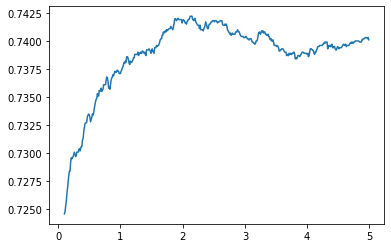

In [0]:
#Improving our Naive Bayes Count Vectorization model

# Create the list of alphas: alphas
alphas = np.arange(0.1, 5, .01)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    cnb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    cnb_classifier.fit(count_train, train_label)
    # Predict the labels: pred
    c_pred = cnb_classifier.predict(count_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(test_label, c_pred)
    return score

best_score = 0
all_scores=[]

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    # print('Alpha: ', alpha)
    # print('Score: ', train_and_predict(alpha))
    # print()
    myscore = train_and_predict(alpha)
    all_scores.append(myscore)
    if myscore>best_score:
      best_score = myscore
      best_alpha = alpha

print(best_alpha, best_score)
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=alphas,y=all_scores)


## Applying Logistoce Regression with Count Vectorization

In [0]:
%%time 

for c in [0.005,0.01, 0.05,0.3, 0.25, 0.75, 0.5, 0.8, 1]:
    
    lr = LogisticRegression(C=c, max_iter=50000 )
    lr.fit(count_train, train_label)
    print ("Training Accuracy for C=%s: %s" 
           % (c,metrics.accuracy_score(train_label, lr.predict(count_train))))
    print ("Test Accuracy for C=%s: %s" 
           % (c, metrics.accuracy_score(test_label, lr.predict(count_test))))
    

    

Training Accuracy for C=0.005: 0.717985195723209
Test Accuracy for C=0.005: 0.722
Training Accuracy for C=0.01: 0.7339009047058039
Test Accuracy for C=0.01: 0.7293
Training Accuracy for C=0.05: 0.7643874897192522
Test Accuracy for C=0.05: 0.7457
Training Accuracy for C=0.3: 0.8004979216218019
Test Accuracy for C=0.3: 0.7486
Training Accuracy for C=0.25: 0.797374797163625
Test Accuracy for C=0.25: 0.7485
Training Accuracy for C=0.75: 0.8153244270567053
Test Accuracy for C=0.75: 0.7473
Training Accuracy for C=0.5: 0.8093226932224865
Test Accuracy for C=0.5: 0.7468
Training Accuracy for C=0.8: 0.816524773823549
Test Accuracy for C=0.8: 0.7466
Training Accuracy for C=1: 0.8197812701447085
Test Accuracy for C=1: 0.7452
CPU times: user 23.4 s, sys: 14.9 s, total: 38.3 s
Wall time: 20.8 s


# TF-IDF Vectorization 

In [0]:
#TfidfVectorizer for text classification

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(train_df["Tweet"])

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(test_df["Tweet"])

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
#print(tfidf_train.A[:10])


['aa', 'aaa', 'aaaamerah', 'aaaand', 'aaah', 'aaahh', 'aafreen', 'aah', 'aahh', 'aahhh']


## Applying Naive Bayes with TFIDF vectorization

Training Naive Bayes on train TFIDF vectors and testing on test TFIDF vectors

In [0]:
%%time

#Training and testing the "Sentiment" model with TfidfVectorizer

# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Create a Multinomial Naive Bayes classifier: nb_classifier
tnb_classifier = MultinomialNB()

# Fit the classifier to the training data
tnb_classifier.fit(tfidf_train, train_label)

# Create the predicted tags: pred
t_pred = tnb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(test_label, t_pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(test_label, t_pred)
print(cm)

print(classification_report(test_label,t_pred))


0.7412
[[2472 1534]
 [1054 4940]]
              precision    recall  f1-score   support

    Negative       0.70      0.62      0.66      4006
    Positive       0.76      0.82      0.79      5994

    accuracy                           0.74     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.74      0.74      0.74     10000

CPU times: user 533 ms, sys: 941 µs, total: 534 ms
Wall time: 535 ms


Cross Validation of Naive Bayes TFIDF Vectorization

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


2.2600000000000002 0.744


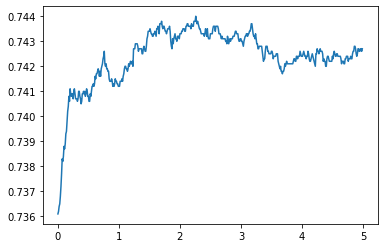

In [0]:
%%time

#Improving our model

# Create the list of alphas: alphas
alphas = np.arange(0, 5, .01)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    tnb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    tnb_classifier.fit(tfidf_train, train_label)
    # Predict the labels: pred
    t_pred = tnb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(test_label, t_pred)
    return score

best_score = 0
all_scores=[]

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    # print('Alpha: ', alpha)
    # print('Score: ', train_and_predict(alpha))
    # print()
    myscore = train_and_predict(alpha)
    all_scores.append(myscore)
    if myscore>best_score:
      best_score = myscore
      best_alpha = alpha

print(best_alpha, best_score)
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=alphas,y=all_scores)


## Applying Logistic Regression with TFIDF Vecotization

In [0]:
%%time

for c in [0.005,0.01, 0.05,0.3, 0.25, 0.75, 0.5, 0.8, 1]:
    
    lr = LogisticRegression(C=c, max_iter=10000, penalty="l2", solver="saga" )
    lr.fit(tfidf_train, train_label)
    print ("Training Accuracy for C=%s: %s" 
           % (c,metrics.accuracy_score(train_label, lr.predict(tfidf_train))))
    print ("Test Accuracy for C=%s: %s" 
           % (c, metrics.accuracy_score(test_label, lr.predict(tfidf_test))))

Training Accuracy for C=0.005: 0.6242358903683286
Test Accuracy for C=0.005: 0.6544
Training Accuracy for C=0.01: 0.6750283415208838
Test Accuracy for C=0.01: 0.6912
Training Accuracy for C=0.05: 0.7394024940538377
Test Accuracy for C=0.05: 0.7338
Training Accuracy for C=0.3: 0.7773356747504835
Test Accuracy for C=0.3: 0.7491
Training Accuracy for C=0.25: 0.7737012914842065
Test Accuracy for C=0.25: 0.7482
Training Accuracy for C=0.75: 0.7974970547046925
Test Accuracy for C=0.75: 0.7525
Training Accuracy for C=0.5: 0.7889056838642274
Test Accuracy for C=0.5: 0.7521
Training Accuracy for C=0.8: 0.7986529441838753
Test Accuracy for C=0.8: 0.7528
Training Accuracy for C=1: 0.8028097005801677
Test Accuracy for C=1: 0.7515
CPU times: user 7.39 s, sys: 8.78 ms, total: 7.39 s
Wall time: 7.39 s


In [0]:
%%time

tfidf_lr = LogisticRegression(C=0.8, max_iter=10000, penalty="l2", solver="saga" )
tfidf_lr.fit(tfidf_train, train_label)
print ("Final Training Accuracy is %s" 
           % (metrics.accuracy_score(train_label, tfidf_lr.predict(tfidf_train))))
print ("Final Test Accuracy is %s" 
           % (metrics.accuracy_score(test_label, tfidf_lr.predict(tfidf_test))))

Final Training Accuracy is 0.7986529441838753
Final Test Accuracy is 0.7528
CPU times: user 809 ms, sys: 1.01 ms, total: 810 ms
Wall time: 811 ms


In [0]:
N = 2
for Sentiment, Sentiment_id in sorted(sentiment_to_id.items()):
  indices = np.argsort(tfidf_lr.coef_[Sentiment_id])
  feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2]
  print("# '{}':".format(Sentiment))
  print("Top unigrams:\n     . {}".format('\n     . '.join(unigrams[-N:])))
  print("Top bigrams:\n      . {}".format('\n     . '.join(bigrams[-N:])))

# 'Negative':
Top unigrams:
     . miss
     . sad
Top bigrams:
      . wont let
     . sorri hear


IndexError: ignored

## Applying Support Vector Machine with TFIDF Vectorization

In [0]:
%%time

from sklearn import svm
from sklearn.metrics import classification_report

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(tfidf_train, train_label)
t1 = time.time()
prediction_linear = classifier_linear.predict(tfidf_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(test_label, prediction_linear, output_dict=True)
print('positive: ', report['Positive'])
print('negative: ', report['Negative'])

Training time: 808.763663s; Prediction time: 32.662524s
positive:  {'precision': 0.7660571964369433, 'recall': 0.8178178178178178, 'f1-score': 0.7910917453401114, 'support': 5994}
negative:  {'precision': 0.6967509025270758, 'recall': 0.626310534198702, 'f1-score': 0.6596555803864861, 'support': 4006}


In [0]:
SVM_score = metrics.accuracy_score(test_label, prediction_linear)
print(SVM_score)

0.7411


## Applying Stochastic Gradient Descent with TFIDF Vectorization

In [0]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier

In [0]:
%%time

# Perform classification with SVM, kernel=linear
SGD_model = SGDClassifier(loss='squared_epsilon_insensitive', penalty='l2',alpha=1e-3, random_state=42,max_iter=1000, tol=None)
t0 = time.time()
SGD_model.fit(tfidf_train, train_label)
t1 = time.time()
prediction_sgd = SGD_model.predict(tfidf_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(test_label, prediction_sgd, output_dict=True)
print('positive: ', report['Positive'])
print('negative: ', report['Negative'])

SGD_score = metrics.accuracy_score(test_label, prediction_sgd)
print(SGD_score)

Training time: 9.872018s; Prediction time: 0.000721s
positive:  {'precision': 0.7492685781158572, 'recall': 0.8545211878545211, 'f1-score': 0.7984411535463756, 'support': 5994}
negative:  {'precision': 0.7243994943109987, 'recall': 0.5721417873190214, 'f1-score': 0.6393305439330543, 'support': 4006}
0.7414
CPU times: user 10.1 s, sys: 101 ms, total: 10.2 s
Wall time: 10.1 s


# Applying Compound Classifier with CountVectorization -> TFIDFtransformer -> Classifier using Pipeline

In [0]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(train_df["Tweet"])

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(test_df["Tweet"])

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:10])

['aa', 'aaa', 'aaaamerah', 'aaaand', 'aaah', 'aaahh', 'aafreen', 'aah', 'aahh', 'aahhh']


In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(count_train)
X_train_tf = tf_transformer.transform(count_train)
X_train_tf.shape

(89974, 17768)

In [0]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(count_train)
X_test_tfidf = tfidf_transformer.transform(count_test)
X_train_tfidf.shape

(89974, 17768)

In [0]:
clf = MultinomialNB(alpha=0.5).fit(X_train_tfidf, train_label)
predicted = clf.predict(X_test_tfidf)
clf_score = metrics.accuracy_score(test_label, predicted)
print(clf_score)

0.7404


In [0]:
%%time
# SVM_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ("svm", SVC(kernel="rbf"))])
t0 = time.time()
SGD = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-3, random_state=42,max_iter=10000, tol=None).fit(X_train_tfidf, train_label)
t1 = time.time()
SGDpredicted = SGD.predict(X_test_tfidf)
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1
#np.mean(predicted == twenty_test.target)
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
SGD_score = metrics.accuracy_score(test_label, SGDpredicted)
print(SGD_score)

Training time: 88.928542s; Prediction time: 0.000682s
0.7419
CPU times: user 1min 28s, sys: 102 ms, total: 1min 29s
Wall time: 1min 28s


## Compound Classifier with SVM

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time

In [0]:
%%time

SVM_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ("svm", SVC(kernel="rbf"))])
t0 = time.time()
SVM_clf.fit(train_df["Tweet"], train_label)
t1 = time.time()
predicted = SVM_clf.predict(test_df["Tweet"])
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1
#np.mean(predicted == twenty_test.target)
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
SVM_score = metrics.accuracy_score(test_label, predicted)
print(SVM_score)

Training time: 2080.846339s; Prediction time: 56.119653s
0.7542
CPU times: user 35min 32s, sys: 2.2 s, total: 35min 35s
Wall time: 35min 36s


In [0]:
report = classification_report(test_label, SVM_predicted, output_dict=True)
print('positive: ', report['Positive'])
print('negative: ', report['Negative'])

positive:  {'precision': 0.7869198312236287, 'recall': 0.8089756423089757, 'f1-score': 0.7977953274103324, 'support': 5994}
negative:  {'precision': 0.70166753517457, 'recall': 0.6722416375436845, 'f1-score': 0.6866394696583376, 'support': 4006}


## Compound Classifier with Multinomial Naive Bayes

In [0]:
%%time
NB_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ("clf", MultinomialNB(alpha = 0.5))])
t0 = time.time()
NB_clf.fit(train_df["Tweet"], train_label)
t1 = time.time()
NB_predicted = NB_clf.predict(test_df["Tweet"])
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1
#np.mean(predicted == twenty_test.target)
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
NB_score = metrics.accuracy_score(test_label, NB_predicted)
print(NB_score)

Training time: 1.092337s; Prediction time: 0.078598s
0.7349
CPU times: user 1.18 s, sys: 3 ms, total: 1.18 s
Wall time: 1.19 s


## Compound Classifier with SGD

In [0]:
%%time
from sklearn.linear_model import SGDClassifier
SGD_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('sgd', SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-3, random_state=42,max_iter=10000, tol=None))])
t0 = time.time()
SGD_clf.fit(train_df["Tweet"], train_label)
t1 = time.time()
SGD_predicted = SGD_clf.predict(test_df["Tweet"])
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1
#np.mean(predicted == twenty_test.target)
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

SGD_score = metrics.accuracy_score(test_label, SGD_predicted)
print(SGD_score)

Training time: 114.302281s; Prediction time: 0.077566s
0.7437
CPU times: user 1min 54s, sys: 118 ms, total: 1min 54s
Wall time: 1min 54s


## Compound Classifier with Logistic Regression

In [0]:
%%time
from sklearn.linear_model import SGDClassifier
lr_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('lr', LogisticRegression(C=0.8, max_iter=50000, penalty="l1", solver="liblinear"))])
t0 = time.time()
lr_clf.fit(train_df["Tweet"], train_label)
t1 = time.time()
lr_predicted = lr_clf.predict(test_df["Tweet"])
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1
#np.mean(predicted == twenty_test.target)
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(test_label, lr_predicted, output_dict=True)
print('positive: ', report['Positive'])
print('negative: ', report['Negative'])
lr_score = metrics.accuracy_score(test_label, lr_predicted)
print(lr_score)

Training time: 1.264947s; Prediction time: 0.078204s
positive:  {'precision': 0.7804568527918782, 'recall': 0.8208208208208209, 'f1-score': 0.8001301024556838, 'support': 5994}
negative:  {'precision': 0.7094155844155844, 'recall': 0.654518222666001, 'f1-score': 0.6808621137366918, 'support': 4006}
0.7542
CPU times: user 1.65 s, sys: 8.99 ms, total: 1.66 s
Wall time: 1.67 s


## Parameter tuning using grid search

In [0]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3) }


In [0]:
%%time
gs_clf = GridSearchCV(lr_clf, parameters, cv=5, n_jobs=-1)
t0 = time.time()

gs_clf = gs_clf.fit(train_df["Tweet"], train_label)
t1 = time.time()

gs_predicted = gs_clf.predict(test_df["Tweet"])
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1
#np.mean(predicted == twenty_test.target)
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))


Training time: 3294.211409s; Prediction time: 0.075186s


0.7404

In [0]:
print(gs_clf.best_score_)

0.7361111111111112


In [0]:
for param_name in sorted(parameters.keys()):
  print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))


clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


# Sentiment Analysis using LSTM


In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
# #combining the dataframes - since we will be extracting the tfidf features 
fullData = train_df.append(test_df, ignore_index=True)
fullData['dataset'] = "Train" 
fullData['dataset'][90000:] = 'Test'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
from collections import Counter

allTweets = ' '.join(fullData['Tweet'])

# create a list of words
Allwords = allTweets.split()

# Count all the words using Counter Method
countOfwords = Counter(Allwords)

total_words = len(Allwords)
sorted_words = countOfwords.most_common(total_words)

In [0]:
total_words

784250

In [0]:
# Tokenizing — Encode the words

tweets_int = []
for tweet in fullData['Tweet']:
    tw = [words_to_int[w] for w in tweet.split()]
    tweets_int.append(tw)
print (tweets_int[0:3])

[[64, 30658, 86], [23, 50, 1019, 1424], [158, 127]]


In [0]:
#  Tokenizing — Encoding the Sentiment labels
encoded_labels = [1 if label =='Positive' else 0 for label in fullData['Sentiment']]
encoded_labels = np.array(encoded_labels)

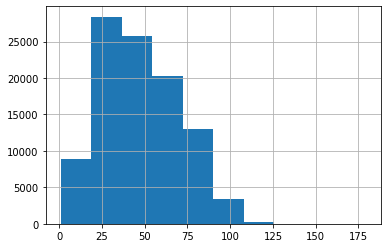

count    99974.000000
mean        47.474973
std         22.727316
min          1.000000
25%         29.000000
50%         45.000000
75%         65.000000
max        179.000000
dtype: float64

In [0]:
# Analyzing Tweet Length
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
tweets_len = [len(x) for x in fullData['Tweet']]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

In [0]:
# Training, Validation and Test split: train= 80% | valid = 10% | test = 10%

# split_frac = 0.8

len_train = tweets_len[0:80000]
train_x = tweets_int[0:80000]
train_y = encoded_labels[0:80000]


len_val = tweets_len[80000:90000]
val_x = tweets_int[80000:90000]
val_y = encoded_labels[80000:90000]


len_test = tweets_len[90000:]
test_x = tweets_int[90000:]
test_y = encoded_labels[90000:]


In [0]:
# Removing Outliers — Getting rid of extremely long or short tweets

train_x = [train_x[i] for i, le in enumerate(len_train) if le>0 ]
train_y = [ train_y[i] for i, le in enumerate(len_train) if le> 0 ]

val_x = [val_x[i] for i, le in enumerate(len_val) if le>0 ]
val_y = [ val_y[i] for i, le in enumerate(len_val) if le> 0 ]

test_x = [test_x[i] for i, le in enumerate(len_test) if le>0 ]
test_y = [ test_y[i] for i, le in enumerate(len_test) if le> 0 ]

In [0]:
# Padding / Truncating the remaining data

def padding_features(tweets_int, seq_length):
    ''' Return features of tweets_ints, where each tweet is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(tweets_int), seq_length), dtype = int)
    
    for i, tweet in enumerate(tweets_int):
        tweets_len = len(tweet)
        
        if tweets_len <= seq_length:
            zeroes = list(np.zeros(seq_length-tweets_len))
            newtweet = zeroes+tweet
        elif tweets_len > seq_length:
            newtweet = tweet[0:seq_length]
        
        features[i,:] = np.array(newtweet)
    
    return features

In [0]:
trainFeatures = padding_features(train_x, 100)
valFeatures = padding_features(val_x, 100)
testFeatures = padding_features(test_x, 100)

In [0]:
# Converting lists into numpy array
Xtrain = np.array(trainFeatures)  
Ytrain = np.array(train_y)  

Xval = np.array(valFeatures) 
Yval = np.array(val_y)

Xtest = np.array(testFeatures)
Ytest = np.array(test_y)


In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(Xtrain), torch.from_numpy(Ytrain))
valid_data = TensorDataset(torch.from_numpy(Xval), torch.from_numpy(Yval))
test_data = TensorDataset(torch.from_numpy(Xtest), torch.from_numpy(Ytest))

# dataloaders
batch_size = 100
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([100, 100])
Sample input: 
 tensor([[    0,     0,     0,  ...,   133,    99,   135],
        [    0,     0,     0,  ...,  5913,    45,   143],
        [    0,     0,     0,  ...,    71,    28,  4569],
        ...,
        [    0,     0,     0,  ...,    55,     4,   161],
        [    0,     0,     0,  ...,    26,     2, 46241],
        [    0,     0,     0,  ..., 71281,   587,  5055]])

Sample label size:  torch.Size([100])
Sample label: 
 tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0])


In [0]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        if torch.cuda.is_available():
          device = 'cuda'
        else:
          device = 'cpu'

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True).to(device)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3).to(device)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size).to(device)
        self.sig = nn.Sigmoid().to(device)

 
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        h = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

        hidden = (h.to(device),h.to(device) ) 
        
        return hidden

In [0]:
%%time

# Instantiate the model w/ hyperparams
vocab_size = len(words_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 512
hidden_dim = 256
n_layers = 3
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
net = net.to(device)
print("Model\n",net)


if torch.cuda.is_available():
  train_on_gpu=True
else:
  train_on_gpu=False

# loss and optimization functions
lr=0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# training params
epochs = 40

print_every = 10
clip=5 # gradient clipping


Model
 SentimentLSTM(
  (embedding): Embedding(102925, 512)
  (lstm): LSTM(512, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)
CPU times: user 2.8 s, sys: 1.03 s, total: 3.83 s
Wall time: 9.98 s


In [0]:
from datetime import datetime
import pytz
 

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

tz = pytz.timezone('America/Chicago') 
datetime_CH = datetime.now(tz)
print(datetime_CH)

2020-06-04 23:27:20.514052-05:00


In [0]:
%%time

trainAcc = []
valAcc = []


# Training the network for specified epochs
for e in range(epochs):
  start = time.time()
  counter = 0
  val_counter = 0
  num_tr_correct = 0
  net.train() 

  # initialize hidden state 
  h = net.init_hidden(batch_size)
  for inputs, labels in train_loader:
    inputs,labels = inputs.to(device), labels.to(device)
    inputs = inputs.type(torch.LongTensor).to(device)
    #checking if the dataset is divisible by batch size, to see if we need to adjust dimensions for the last batch 
    if Xtrain.shape[0]%batch_size !=0:
      if counter >=Xtrain.shape[0] - Xtrain.shape[0]%batch_size :
        h = net.init_hidden(Xtrain.shape[0]%batch_size)
    counter+=batch_size

    inputs,labels = inputs.to(device), labels.to(device)
    
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data.to(device) for each in h])

    # zero accumulated gradients
    net.zero_grad()        
    
    # get the output from the model
    inputs = inputs.type(torch.LongTensor).to(device)
    output, h = net(inputs, h)

    # calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()

    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(net.parameters(), clip)
    optimizer.step()

    # training accuracy
    trainpred = torch.round(output.squeeze()) 
    # compare predictions to true label
    correct_train_tensor = trainpred.eq(labels.float().view_as(trainpred))
    correct_train = np.squeeze(correct_train_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_train_tensor.cpu().numpy())
    num_tr_correct += np.sum(correct_train)


  # accuracy over all validation data
  train_acc = num_tr_correct/Xtrain.shape[0]
  trainAcc.append(train_acc)

  
  val_h = net.init_hidden(batch_size)    
  val_losses = []
  num_correct = 0
  
  net.eval()
  for inputs, labels in valid_loader:
    inputs,labels = inputs.to(device), labels.to(device) #sending data to the device
    inputs = inputs.type(torch.LongTensor).to(device) 
    #checking if the dataset is divisible by batch size, to see if we need to adjust dimensions for the last batch    
    if Xval.shape[0]%batch_size !=0: 
      if val_counter>=Xval.shape[0] - Xval.shape[0]%batch_size: #adjust for the last batch
        val_h = net.init_hidden(Xval.shape[0]%batch_size)

    val_counter+=batch_size        

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    val_h = tuple([each.data.to(device) for each in val_h])
    output, val_h = net(inputs, val_h)


    val_loss = criterion(output.squeeze(), labels.float())
    val_losses.append(val_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


    # accuracy over all validation data
    val_acc = num_correct/Xval.shape[0]
    valAcc.append(val_acc)
      

  net.train()
  print("Epoch: {}/{}...".format(e+1, epochs),
        "Val Loss: {:.3f}".format(np.mean(val_losses)),
        "Train accuracy: {:.3f}".format(train_acc),
        "Valid accuracy: {:.3f}".format(val_acc),
        "Epoch Time", timeSince(start)," ", datetime.now(tz))



Epoch: 1/40... Val Loss: 0.677 Train accuracy: 0.558 Valid accuracy: 0.585 Epoch Time 1m 9s   2020-06-04 23:28:38.181550-05:00
Epoch: 2/40... Val Loss: 0.618 Train accuracy: 0.576 Valid accuracy: 0.660 Epoch Time 1m 9s   2020-06-04 23:29:47.612762-05:00
Epoch: 3/40... Val Loss: 0.572 Train accuracy: 0.674 Valid accuracy: 0.699 Epoch Time 1m 9s   2020-06-04 23:30:57.386792-05:00
Epoch: 4/40... Val Loss: 0.545 Train accuracy: 0.710 Valid accuracy: 0.724 Epoch Time 1m 9s   2020-06-04 23:32:07.347710-05:00
Epoch: 5/40... Val Loss: 0.536 Train accuracy: 0.730 Valid accuracy: 0.727 Epoch Time 1m 9s   2020-06-04 23:33:17.246014-05:00
Epoch: 6/40... Val Loss: 0.542 Train accuracy: 0.749 Valid accuracy: 0.723 Epoch Time 1m 9s   2020-06-04 23:34:27.102585-05:00
Epoch: 7/40... Val Loss: 0.525 Train accuracy: 0.763 Valid accuracy: 0.739 Epoch Time 1m 9s   2020-06-04 23:35:37.014484-05:00
Epoch: 8/40... Val Loss: 0.530 Train accuracy: 0.779 Valid accuracy: 0.734 Epoch Time 1m 9s   2020-06-04 23:36:

In [0]:
#performance 

perf = [trainAcc,valAcc]
perf = pd.DataFrame(perf).transpose()
perf = perf.reset_index()
perf.columns = ["Epoch","Training", "Validation"]

In [0]:
d1 = pd.melt(perf, id_vars = ['Epoch'],value_vars=["Training", "Validation"])[:epochs]
d2 = pd.melt(perf, id_vars = ['Epoch'],value_vars=["Training", "Validation"])[-(epochs):]
data1 = d1.append(d2, ignore_index=True)
data1["Epoch"] = [i+1 for i in range(epochs)] + [i+1 for i in range(epochs)]
data1.columns = ['Epoch', 'Mode', 'Accuracy']
# data1

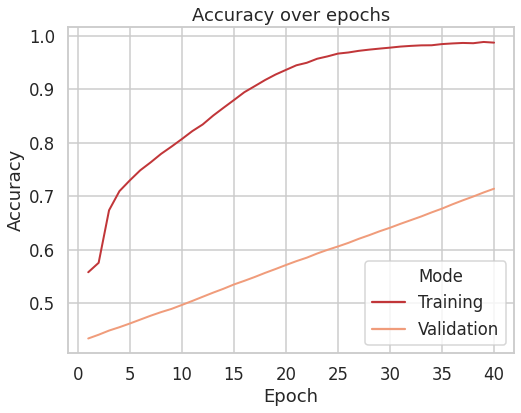

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set("talk")
sns.set_style('whitegrid')
sns.set_palette("RdBu")
fig, ax =plt.subplots(1,1 , figsize=(8,6))
g = sns.lineplot(x='Epoch', y='Accuracy', hue='Mode', data=data1, linewidth=2)
g.set_title("Accuracy over epochs")
plt.show()


In [0]:
%%time 

# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)
test_counter = 0
net.eval()
# iterate over test data
for inputs, labels in test_loader:
  
  if test_counter >=Xtest.shape[0] - Xtest.shape[0]%batch_size:
    if Xtest.shape[0]%batch_size !=0:
      print("Change at ",test_counter)
      h = net.init_hidden(Xtest.shape[0]%batch_size)

  test_counter +=batch_size

  # print(test_counter)


  # Creating new variables for the hidden state, otherwise
  # we'd backprop through the entire training history
  h = tuple([each.data.to(device) for each in h])

    
  inputs, labels = inputs.to(device), labels.to(device)
  
  # get predicted outputs
  inputs = inputs.type(torch.LongTensor).to(device)
  output, h = net(inputs, h)
  
  # calculate loss
  test_loss = criterion(output.squeeze(), labels.float())
  test_losses.append(test_loss.item())
  
  # convert output probabilities to predicted class (0 or 1)
  pred = torch.round(output.squeeze())  # rounds to the nearest integer
  
  # compare predictions to true label
  correct_tensor = pred.eq(labels.float().view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Change at  9900
Test loss: 2.173
Test accuracy: 0.714
CPU times: user 1.32 s, sys: 478 ms, total: 1.8 s
Wall time: 1.8 s


# Alternative code for text pre-processing

In [0]:
# def clean_tweet(tweet):
#     return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [0]:
#Data cleaning and prepocessing - setting up a cleaning fucntion
# import re
# from nltk.tokenize import word_tokenize
# from string import punctuation 
# from nltk.corpus import stopwords 
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# def dataclean(mydataframe,index):
#   mydataframe.iloc[:,index] = np.vectorize(remove_pattern)(mydataframe.iloc[:,index], "@[\w]*")#removing handles
#   mydataframe.iloc[:,index] = mydataframe.iloc[:,index].str.replace("[^a-zA-Z#]", " ")#removing special charectars
#   mydataframe.iloc[:,index] = mydataframe.iloc[:,index].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))#removing short words
#   mydataframe.iloc[:,index] = mydataframe.iloc[:,index].apply(lambda x: " ".join(x.lower() for x in x.split()))#lower case

#   #removing stop words
#   stop = stopwords.words('english')
#   mydataframe.iloc[:,index] = mydataframe.iloc[:,index].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#   #apply stemming
#   st = nltk.PorterStemmer()
#   mydataframe.iloc[:,index] = mydataframe.iloc[:,index].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#   mydataframe.head()

#   return mydataframe

# def remove_pattern(input_txt, pattern):
#     r = re.findall(pattern, input_txt)
#     for i in r:
#         input_txt = re.sub(i, '', input_txt)
        
#     return input_txt


In [0]:
#cleaning up the training and test data

# %time train_df = dataclean(train_df,2)
# %time test_df = dataclean(test_df,2)


In [0]:
# train_df = train_df.rename({"SentimentText": "Tweet"}, axis=1, inplace=False)
# test_df = test_df.rename({"SentimentText": "Tweet"}, axis=1, inplace=False)